#  March Madness Predictor
By: Eric Huang(ceh256), Harrison Chin(hc955), Julie Jeong(sj598)

Hypothesis: Predict the top 68 teams in the March Madness Competitition
Looking at our results, the top team should be the winner, while the next two should be in the 2ND round, and so forth.

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import io

Reading our dataset, we got it from https://www.kaggle.com/andrewsundberg/college-basketball-dataset?select=cbb.csv.
It includes year 2013-2019. 2021 did not have finished data and 2020 was what we are trying to predict.

In [3]:
cbb=pd.read_csv('cbb.csv')

Here, we preproccessed our data and changed the catagorical varible of POSTSEASON to a number, and also added two new varibles, Winrate, which are determined by the amount of games won and number of games played, and WAB Winrate which are determined by the amount of games won above the bubble and number of games played.

In [4]:
#low numbers = better (0-8)
postseasonmapping = {'Champions':0,'2ND':1,'F4':2,'E8':3,'S16':4,'R32':5,'R64':6,'R68':7}
cbb['POSTSEASON'] = cbb['POSTSEASON'].map(postseasonmapping)
cbb['POSTSEASON'] = cbb['POSTSEASON'].fillna(8)# teams that do not make it are given a value of 8
cbb["W_R"] = cbb["W"]/cbb["G"]
cbb["WAB_R"] = cbb["WAB"]/cbb["G"]

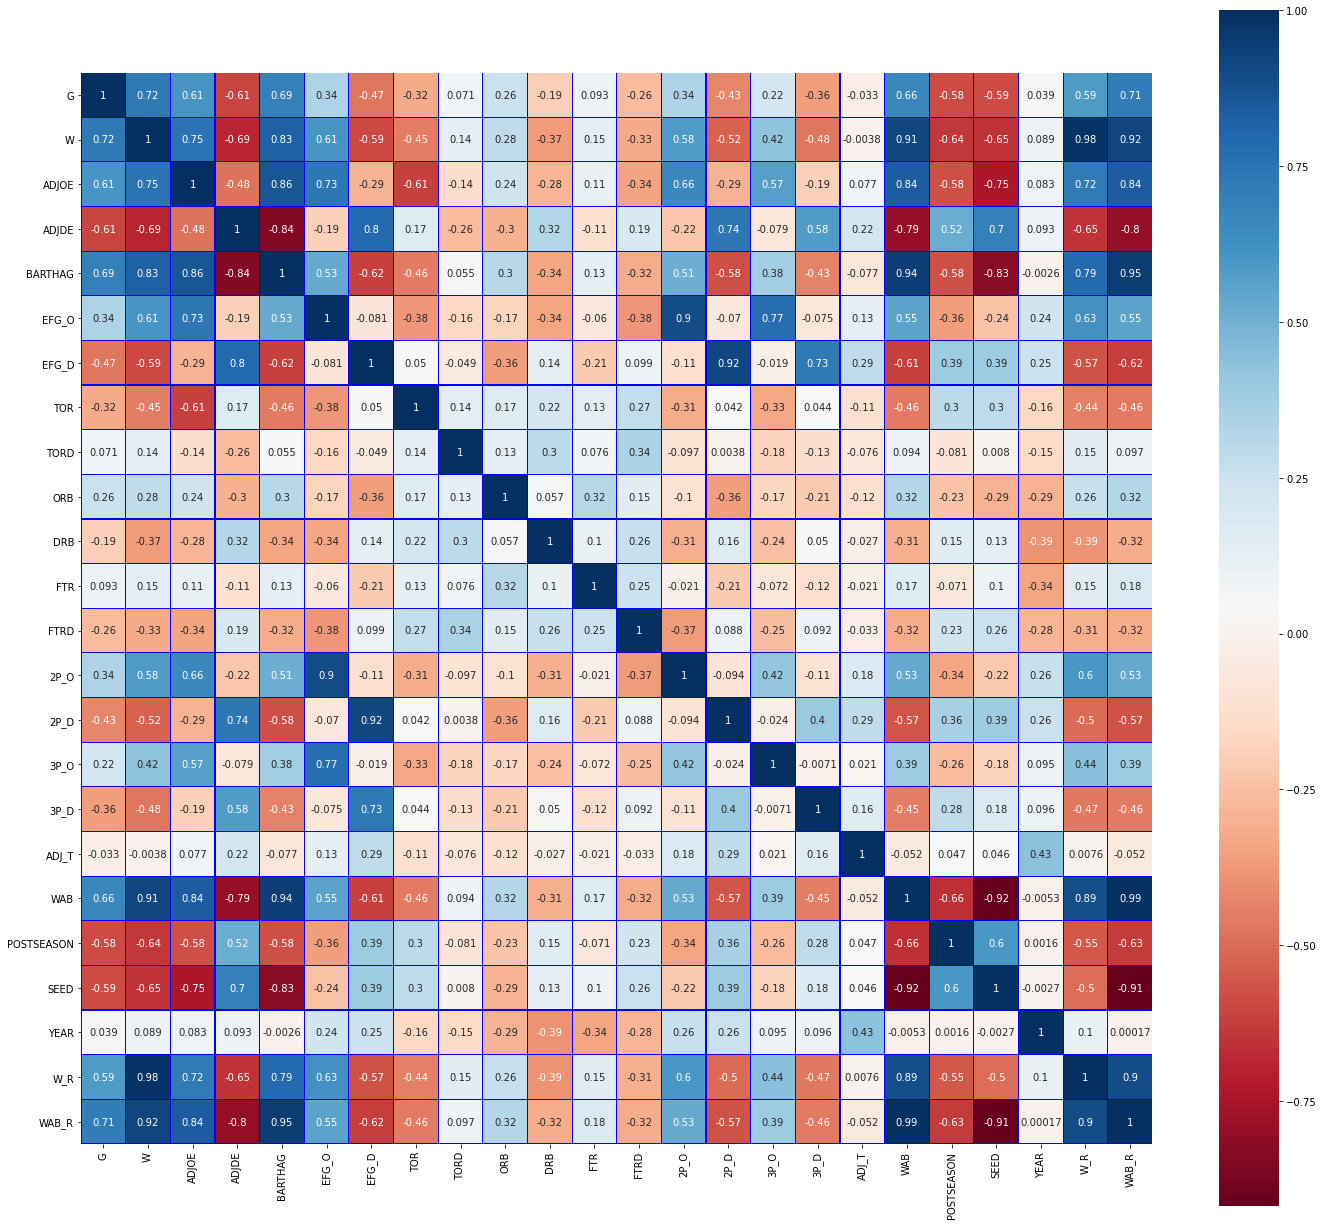

In [5]:
corr = cbb.corr()
plt.figure(figsize=(24,22))
sns.heatmap(corr, linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, linecolor='blue', annot=True) 
plt.show()

By looking at the correlation matrix, we can see that 'ADJOE', 'ADJDE','BARTHAG','W_R','WAB_R' have numbers close to -1 and 1, When we use postseason as our target varible. SEED is also high, but we did not use it because the 2020 data does not include a SEED column.


First, we used a linear regression model with our 5 variables and POSTSEASON as the target.

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

features = cbb[['ADJOE', 'ADJDE','BARTHAG','W_R','WAB_R']]
target = cbb['POSTSEASON']
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=.2,random_state=42)
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
linear_predictions = linear_model.predict(x_test)
y=np.round(linear_predictions)#because it is a linear regression, we need to round the numbers to integers.
y[y>8]=8#change everyteam that did worse than 8 in POSTSEASON back down to 8.

print("Accuracy Score:", accuracy_score(y_test, y)) 
print("Mean Squared Error:", mean_squared_error(y, y_test)) 

Accuracy Score: 0.5274949083503055
Mean Squared Error: 0.6354378818737271


The accuracy score was very low, but the low mean squared error shows that it does get the teams in the general trend area.

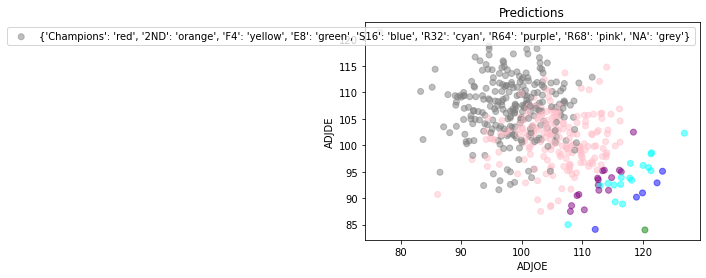

In [7]:
colors = {0:'red',1:'orange',2:'yellow',3:'green',4:'blue',5:'cyan',6:'purple',7:'pink',8:'grey'}
labels = {'Champions':'red','2ND':'orange','F4':'yellow','E8':'green','S16':'blue','R32':'cyan','R64':'purple','R68':'pink','NA':'grey','NA':'grey'}

df = pd.DataFrame()
df["POSTSEASON"] = pd.Series(y)
x = plt.scatter(x_test['ADJOE'], x_test['ADJDE'],c=df['POSTSEASON'].map(colors), label = labels, alpha=.5)

plt.title('Predictions')
plt.xlabel('ADJOE')
plt.ylabel('ADJDE')
plt.legend()
plt.show()

We assigned a color to each position, and graphed it out comparing Adjusted Defensive Efficiency and Adjusted Offensive Efficiency. As we can see, teams with higher Offensive efficiency tend to do well, while Defensive efficiency seems to be less important.

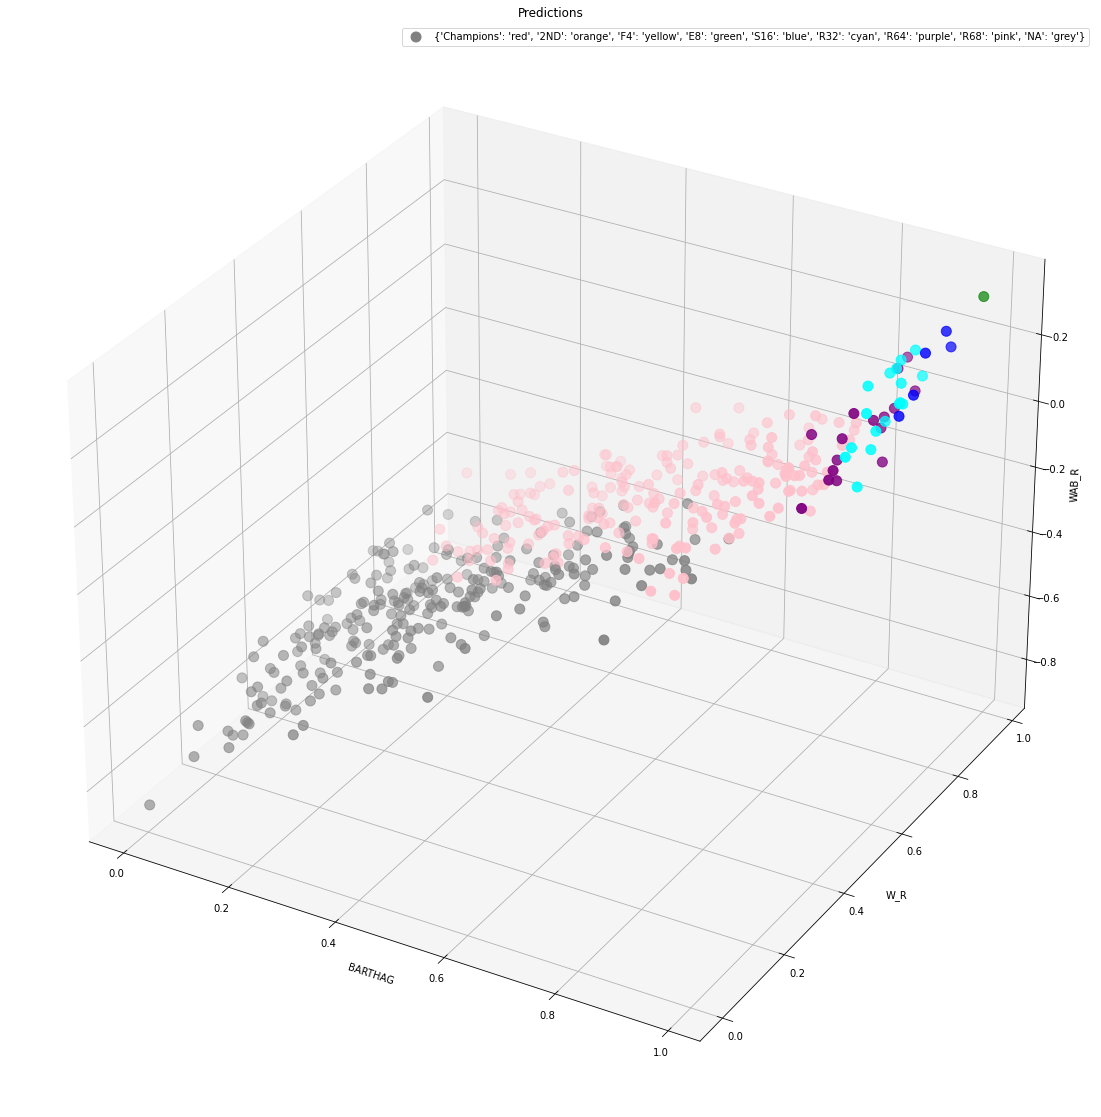

In [8]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_test['BARTHAG'], x_test['W_R'],x_test['WAB_R'], s=100, c=df['POSTSEASON'].map(colors), label = labels)

ax.set_title('Predictions')
ax.set_xlabel('BARTHAG')
ax.set_ylabel('W_R')
ax.set_zlabel('WAB_R')

plt.legend()
plt.show()

In this 3D plot, we plotted the Power Rating, Win Rate, Wins Above Bubble Rate and found that the teams with higher values in all three categories tended to do better than the teams who were lower. 

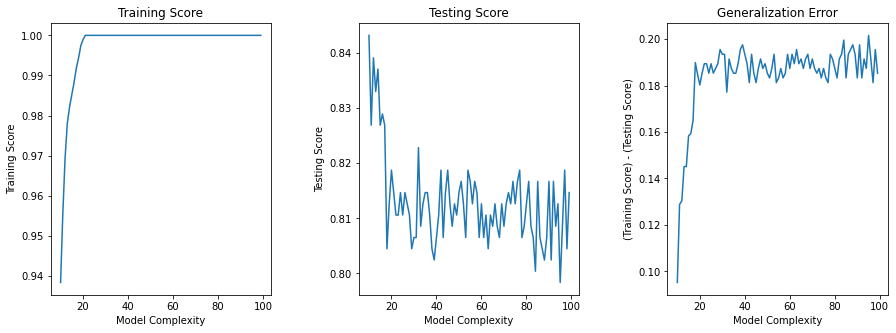

In [9]:
from sklearn.tree import DecisionTreeClassifier

train_scores = []
test_scores = []

max_depths = list(range(10,100))
for i in max_depths:
    model = DecisionTreeClassifier(max_depth=i)

    model.fit(x_train, y_train)
    
    train_scores.append(model.score(x_train, y_train))
    test_scores.append(model.score(x_test, y_test))

plt.subplots(figsize=(15,5))
plt.subplots_adjust(wspace=0.4)
plt.subplot(131)
plt.plot(max_depths, train_scores)
plt.title('Training Score')
plt.xlabel('Model Complexity')
plt.ylabel('Training Score')
plt.subplot(132)
plt.plot(max_depths, test_scores)
plt.title("Testing Score")
plt.xlabel('Model Complexity')
plt.ylabel('Testing Score')
plt.subplot(133)
plt.plot(max_depths, np.subtract(train_scores,test_scores))
plt.title("Generalization Error")
plt.xlabel('Model Complexity')
plt.ylabel('(Training Score) - (Testing Score)')
plt.show()

In this box, we used the for loop to find the optimal depth for a DecisionTreeClassifier and came to the conclusion that 20 was the best depth for our model based off of the graphs. 

In [10]:
decision_model = DecisionTreeClassifier(max_depth=20)

decision_model.fit(x_train, y_train)
decision_predictions = decision_model.predict(x_test)

y2=np.round(decision_predictions)
y2[y2>8]=8

print("Accuracy Score:", accuracy_score(y_test, y2)) 
print("Mean Squared Error:", mean_squared_error(y2, y_test)) 

Accuracy Score: 0.8187372708757638
Mean Squared Error: 0.6883910386965377


Using the DecisionTreeClassifier, we saw higher accuracy values so we decided to use it for further modeling.

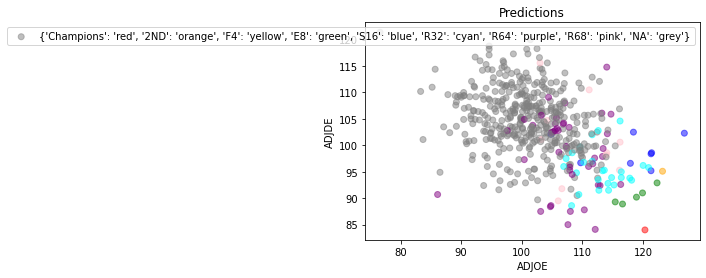

In [11]:
colors = {0:'red',1:'orange',2:'yellow',3:'green',4:'blue',5:'cyan',6:'purple',7:'pink',8:'grey'}
labels = {'Champions':'red','2ND':'orange','F4':'yellow','E8':'green','S16':'blue','R32':'cyan','R64':'purple','R68':'pink','NA':'grey','NA':'grey'}

df2 = pd.DataFrame()
df2["POSTSEASON"] = pd.Series(y2)
x = plt.scatter(x_test['ADJOE'], x_test['ADJDE'],c=df2['POSTSEASON'].map(colors), label = labels, alpha=.5)

plt.title('Predictions')
plt.xlabel('ADJOE')
plt.ylabel('ADJDE')
plt.legend()
plt.show()

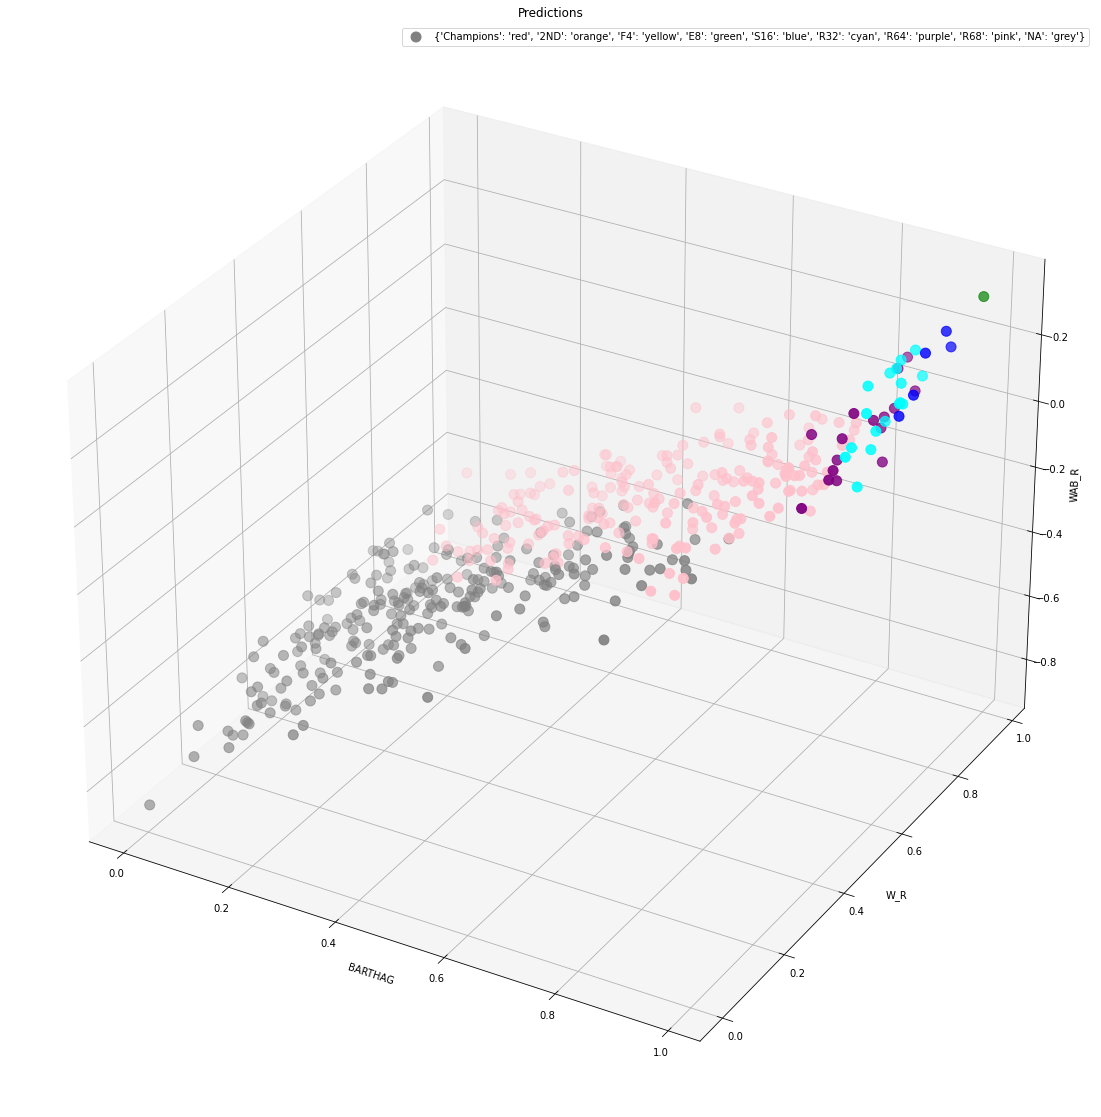

In [12]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_test['BARTHAG'], x_test['W_R'],x_test['WAB_R'], s=100, c=df['POSTSEASON'].map(colors), label = labels)

ax.set_title('Predictions')
ax.set_xlabel('BARTHAG')
ax.set_ylabel('W_R')
ax.set_zlabel('WAB_R')

plt.legend()
plt.show()

Based off our 2D and 3D scatter plots, we were unable to determine a champion utilizing our models, so in the next lines we decided to print the ordering of the teams in order to determine who the champion would be. The champion would most likely be the 0th index because they would have the best stats overall and most likely win the whole tournament.

In [13]:
cbb20=pd.read_csv('cbb20.csv')

In [14]:
cbb20["W_R"] = cbb20["W"]/cbb20["G"]
cbb20["WAB_R"] = cbb20["WAB"]/cbb20["G"]
features_2020=cbb20[['ADJOE', 'ADJDE','BARTHAG','W_R','WAB_R']]
predictions_2020 = decision_model.predict(features_2020)
cbb20['POSTSEASON_PRED']=predictions_2020 #We added this data frame in order to house our prediction data from our model
cbb20.sort_values(by=['POSTSEASON_PRED']) #We sorted our values in ascending order

for i in range(0,68):
    print(i,':', cbb20.loc[i,'TEAM'])

0 : Kansas
1 : Baylor
2 : Gonzaga
3 : Dayton
4 : Michigan St.
5 : Duke
6 : Creighton
7 : Ohio St.
8 : Louisville
9 : San Diego St.
10 : Villanova
11 : Houston
12 : Arizona
13 : Michigan
14 : Penn St.
15 : West Virginia
16 : BYU
17 : Oregon
18 : Wisconsin
19 : Florida St.
20 : Seton Hall
21 : Texas Tech
22 : Purdue
23 : Butler
24 : Providence
25 : Maryland
26 : Minnesota
27 : Kentucky
28 : Illinois
29 : Rutgers
30 : Iowa
31 : Florida
32 : Marquette
33 : Virginia
34 : Wichita St.
35 : Indiana
36 : Oklahoma
37 : Utah St.
38 : Auburn
39 : Xavier
40 : Saint Mary's
41 : Colorado
42 : LSU
43 : Syracuse
44 : Stanford
45 : North Carolina St.
46 : Cincinnati
47 : Richmond
48 : Mississippi St.
49 : Saint Louis
50 : Georgia Tech
51 : Arkansas
52 : Oklahoma St.
53 : Washington
54 : Notre Dame
55 : Connecticut
56 : St. John's
57 : USC
58 : Arizona St.
59 : Alabama
60 : South Carolina
61 : Tennessee
62 : Memphis
63 : Northern Iowa
64 : San Francisco
65 : VCU
66 : Texas
67 : Davidson


From this, we can see that Kansas would be our champion for the 2020 March Madness Tournament, 2nd place would be Baylor, Gonzaga and Dayton were eliminated in the Final Four and so on. 